In [43]:
!pip install google-auth google-auth-oauthlib google-auth-httplib2
!pip install google-api-python-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.2/189.2 kB 676.8 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 324.1 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 644.5 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 182.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 17.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 501.0 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.1/229.1 kB 875.7 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 135.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 1.0 MB/s eta 0:00:00ta 0:00:01


In [45]:
# Authenticate with service account credentials
from google.oauth2 import service_account
from google.auth.transport.requests import Request
# Access Google Drive using the authenticated credentials
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload,MediaIoBaseDownload
import os
import io
from google_drive_utils import *
from helper_utils import *

In [47]:
drive_service = get_drive_service()
get_dataset_from_drive(drive_service)

fount dataset in drive
starting download...
Download 31.
Download 63.
Download 95.
Download 100.


In [48]:
!unzip apnea-ecg-database-1.0.0.zip -d apnea-ecg-database-1.0.0

Archive:  apnea-ecg-database-1.0.0.zip
   creating: apnea-ecg-database-1.0.0/challenge/
replace apnea-ecg-database-1.0.0/x02.apn? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [11]:
%pip install wfdb
%pip install seaborn
%pip install scipy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [49]:
# import the WFDB package
import wfdb
import numpy as np
import scipy
from scipy.signal import butter, filtfilt, cheby1, freqz
import matplotlib.pyplot as plt

### Autocorrelation function (ACF) (https://stackoverflow.com/questions/643699/how-can-i-use-numpy-correlate-to-do-autocorrelation)

In [50]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')[len(x)-1:]
    print(result.size)
    return result
def get_weights(correlation):
  return np.sum(correlation, axis = 0)

## Signal Preprocessing

In [51]:
def chebyshev_filter(record):
  # Sampling parameters
  fs = 100  # Hz, as given in the dataset description

  # Desired filter parameters
  order = 5 # Polynomial order of the waveform (this current value is an estimation)
  Apass = 1.5  # dB, pass-band attuenation which I believe is max allowable amplitude
  fcut = 48    # Hz, cut-off frequency (research paper used 0.5 and 48 Hz)

  # Normalized frequency argument for cheby1
  wn = fcut / (0.5*fs) # Value to be within 0 and 1

  [b, a] = cheby1(order, Apass, wn)

  w, h = freqz(b, a, worN=8000)

  sos = cheby1(order, Apass, wn, output="sos")

  signal = record.p_signal
  # print(signal.shape)
  filtered_signal = scipy.signal.sosfilt(sos, signal)
  return filtered_signal

In [52]:
from scipy.signal import spectrogram
from scipy.signal.windows import gaussian
def create_spectrogram(signal, nfft = 128, sample_frequency = 100, stride = 0):
  # print(signal.shape)
  signal_spectrogram,freq,t,im = plt.specgram(signal, Fs = sample_frequency, NFFT = nfft, noverlap=stride, cmap = 'jet_r')
  return signal_spectrogram,freq,t

# LSTM Model

In [53]:
import torchvision
from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import io
import torchvision
import torchvision.transforms as T

### Dataset

In [54]:
def get_spectrogram_and_annotations(file_path, fs = 100):
  """Split up spectrogram into segments of around 60s in length"""
  signal_record = wfdb.rdrecord(file_path)
  signal = wfdb.rdrecord(file_path).p_signal
  signal_length = len(signal)
  filtered_signal = chebyshev_filter(signal_record)
  filtered_signal = np.array(filtered_signal).flatten()
  spectrogram,freqs,times = create_spectrogram(filtered_signal)
  spectrogram_length = spectrogram.shape[1]
  annotations = [[t] for t in wfdb.rdann(file_path, extension = "apn").symbol]
  num_annotations = len(annotations)
  # spectrogram_segment_width = np.max(np.where(times < 60))
  # spectrogram_gap = spectrogram_length // num_annotations
  # spectrogram_end = (signal_length / fs) // num_annotations * num_annotations
  segment_spectrograms = []
  segment_times = []
  time_gap = round(signal_length / fs / num_annotations,1)
  time_window_start = 0
  time_window_end = time_gap
  start_index = -1
  end_index = -1
  while time_window_end <= times[-1]:
    start_index = np.min(np.where(times >= time_window_start))
    end_index = np.min(np.where(times >= time_window_end))
    segment_spectrograms.append(spectrogram[:,start_index:end_index])
    segment_times.append(times[start_index:end_index])
    time_window_start+=time_gap
    time_window_end+=time_gap
  if len(segment_spectrograms) < num_annotations:
    start_index =  np.min(np.where(times >= time_window_start))
    segment_spectrograms.append(spectrogram[:,start_index:-1])
  correct_spectrogram_shape = segment_spectrograms[0].shape[1]
  print(f"number of spectrograms: {len(segment_spectrograms)}, number of annotations: {len(annotations)}")
  assert(len(segment_spectrograms) == len(annotations))
  for i,spec in enumerate(segment_spectrograms):
    if abs(spec.shape[1] - correct_spectrogram_shape)>5:
      print('different spectrogram shape at index',i)
      print(i, spec.shape)
  correct_annotation_shape = len(annotations[0])
  for i,ann in enumerate(annotations):
    if abs(len(ann) - correct_annotation_shape)>5:
      print('different annotation shape at index',i)
      print(i, len(ann))
    assert(len(ann) == correct_annotation_shape)
  return segment_spectrograms,annotations

### Creating feature transformation objects for pre processing

In [55]:
# from https://www.kaggle.com/code/smjishanulislam/audio-mnist-with-pytorch
feature_transform_resize = T.Compose([
    T.ToPILImage(), # convert spectrogram to image
    T.Resize((100,100)),
    T.ToTensor() # convert to tensor
])

feature_transform = T.Compose([
    T.ToPILImage(), # convert spectrogram to image
    T.ToTensor() # convert to tensor
])

In [56]:
class SpectrogramDataset(Dataset):
  def __init__(self, file_paths = [], resize_spectrogram = True):
    super().__init__()
    self.spectrograms = []
    self.annotations = []
    self.resize_spectrogram = resize_spectrogram
    # add data from multiple files to this dataset
    for file_path in file_paths:
      segment_spectrograms, segment_annotations = get_spectrogram_and_annotations(file_path)
      self.spectrograms.extend(segment_spectrograms)
      self.annotations.extend(segment_annotations)
    self.spectrograms = [torch.from_numpy(spectrogram) for spectrogram in self.spectrograms]

  def __getitem__(self, idx):
    src = feature_transform_resize(self.spectrograms[idx]) * 10000 \
      if self.resize_spectrogram \
      else feature_transform(self.spectrograms[idx]) * 10000 
    trg = self.annotations[idx]
    trg = self.annotations[idx]
    if trg[0] == "N":
      trg[0] = 0
    elif trg[0] == "A":
      trg[0] = 1
    return src, trg
  def __len__(self):
    return len(self.spectrograms)

### Reading files

In [57]:
import os
dataset_path = "apnea-ecg-database-1.0.0"
train_file_names = ["a01","a02","a03","a04","a05","b01","b02","b03","b04","b05","c01","c02","c03","c04","c05","x01","x02","x03","x04","x05","x06","x07"]

# create file path list for dataset
train_file_paths = [os.path.join(dataset_path, file_name) for file_name in train_file_names]
print("===> distribution of annotations across files")
for filename in train_file_paths:
  annotation = wfdb.rdann(filename, extension="apn")
  # Find out which heading contains the labels
  annotation.get_label_fields()
  # Count number of Apnea-tagged intervals
  annotation.symbol.count("A")
  # The readings are labelled normal (N) or atrial premature contraction (A)
  # There should be 470 As and 19 Ns for "a01"
  print(filename)
  print(np.unique(annotation.symbol, return_counts=True))

===> distribution of annotations across files
apnea-ecg-database-1.0.0/a01
(array(['A', 'N'], dtype='<U1'), array([470,  19]))
apnea-ecg-database-1.0.0/a02
(array(['A', 'N'], dtype='<U1'), array([420, 108]))
apnea-ecg-database-1.0.0/a03
(array(['A', 'N'], dtype='<U1'), array([246, 273]))
apnea-ecg-database-1.0.0/a04
(array(['A', 'N'], dtype='<U1'), array([453,  39]))
apnea-ecg-database-1.0.0/a05
(array(['A', 'N'], dtype='<U1'), array([276, 178]))
apnea-ecg-database-1.0.0/b01
(array(['A', 'N'], dtype='<U1'), array([ 19, 468]))
apnea-ecg-database-1.0.0/b02
(array(['A', 'N'], dtype='<U1'), array([ 93, 424]))
apnea-ecg-database-1.0.0/b03
(array(['A', 'N'], dtype='<U1'), array([ 73, 368]))
apnea-ecg-database-1.0.0/b04
(array(['A', 'N'], dtype='<U1'), array([ 10, 419]))
apnea-ecg-database-1.0.0/b05
(array(['A', 'N'], dtype='<U1'), array([ 57, 376]))
apnea-ecg-database-1.0.0/c01
(array(['N'], dtype='<U1'), array([484]))
apnea-ecg-database-1.0.0/c02
(array(['A', 'N'], dtype='<U1'), array([  1,

In [58]:
# dataset for multiple segments per iteration
# in __getitem__, comment src = feature_transform_resize(self.spectrograms[idx]) * 10000 and uncomment src = [feature_transform(self.spectrograms[_idx]) * 10000 for _idx in range(idx,min(idx+5,len(self)-1))]
# for no added padding

class MultiSpectrogramDataset(Dataset):
  def __init__(self, file_paths = [], segment_length = 6000, spectrogram_segment_length = 23, num_segments = 10):
    super().__init__()
    self.spectrograms = []
    self.annotations = []
    # add data from multiple files to this dataset
    for file_path in file_paths:
      signal_length = len(wfdb.rdrecord(file_path).p_signal)
      print(signal_length)
      signal_segments = [wfdb.rdrecord(file_path, sampfrom = start_index, sampto = min(signal_length, start_index + segment_length))
                        for start_index in range(0, signal_length, segment_length)]
      filtered_signal_segments = [chebyshev_filter(signal) for signal in signal_segments]
      segment_annotations = [v for v in wfdb.rdann(file_path, extension="apn").symbol]
      segment_spectrograms = [create_spectrogram(np.array(filtered_signal).flatten())[0]
                           for filtered_signal in filtered_signal_segments]
      segment_annotations = segment_annotations[:-1]
      segment_spectrograms = segment_spectrograms[:len(segment_annotations)]
      self.spectrograms.extend(segment_spectrograms)
      self.annotations.extend(segment_annotations)
      print(f"number of spectrograms: {len(self.spectrograms)}, number of annotations: {len(self.annotations)}")
  def __getitem__(self, idx):
    # src = feature_transform_resize(self.spectrograms[idx]) * 10000
    src = [feature_transform(self.spectrograms[_idx]) * 10000 for _idx in range(idx,min(idx+5,len(self)-1))]
    src = torch.concat(src,dim=2)
    print('src shape after first stack',src.shape)
    trg = self.annotations[idx: idx + 5]
    for i in range(len(trg)):
      if trg[i] == "N":
        trg[i] = 0
      elif trg[i] == "A":
        trg[i] = 1
    return src, trg
  def __len__(self):
    return len(self.spectrograms)

In [59]:
def collate_fn(data):
  return data
dataset_path = "apnea-ecg-database-1.0.0"

train_file_names = set(sorted([filename[:3]
                      for dirname, _, filenames in os.walk(dataset_path)
                      for filename in filenames
                      if (filename.startswith("a")
                      or filename.startswith("b")
                      or filename.startswith("c"))
                      and len(filename) <= 7
                      and "apn" in str(filename)]))
test_file_names = set(sorted([filename[:3]
                      for dirname, _, filenames in os.walk(dataset_path)
                      for filename in filenames
                      if filename.startswith("x")
                      and len(filename) <= 7
                      and "apn" in str(filename)]))
print('train file names')
print(train_file_names)
print(len(train_file_names))
print('test file names')
print(test_file_names)
print(len(test_file_names))

train file names
{'c09', 'a15', 'a03', 'a04', 'c05', 'a19', 'c10', 'a07', 'a14', 'c08', 'c02', 'b04', 'b03', 'b01', 'a02', 'c01', 'a10', 'a09', 'c07', 'a08', 'a06', 'a16', 'c03', 'a11', 'b05', 'a01', 'a17', 'a12', 'a18', 'c06', 'c04', 'a13', 'a20', 'a05', 'b02'}
35
test file names
{'x21', 'x20', 'x29', 'x15', 'x18', 'x22', 'x17', 'x02', 'x10', 'x35', 'x04', 'x13', 'x32', 'x08', 'x31', 'x14', 'x24', 'x01', 'x09', 'x28', 'x06', 'x11', 'x27', 'x23', 'x12', 'x19', 'x26', 'x30', 'x05', 'x16', 'x07', 'x03', 'x33', 'x34', 'x25'}
35


### Create SpectrogramDataset object 

#### *Might take a while*

initialising train dataset for 35 files


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 468, number of annotations: 468


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 510, number of annotations: 510


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 519, number of annotations: 519


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 492, number of annotations: 492
different spectrogram shape at index 491
491 (65, 34)
number of spectrograms: 466, number of annotations: 466


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 502, number of annotations: 502


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 431, number of annotations: 431
different spectrogram shape at index 430
430 (65, 38)
number of spectrograms: 511, number of annotations: 511


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 509, number of annotations: 509


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 513, number of annotations: 513


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 502, number of annotations: 502


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 429, number of annotations: 429
different spectrogram shape at index 428
428 (65, 38)
number of spectrograms: 441, number of annotations: 441
number of spectrograms: 487, number of annotations: 487


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 528, number of annotations: 528
different spectrogram shape at index 527
527 (65, 31)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 484, number of annotations: 484
number of spectrograms: 517, number of annotations: 517


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 495, number of annotations: 495
different spectrogram shape at index 494
494 (65, 31)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 429, number of annotations: 429
different spectrogram shape at index 428
428 (65, 40)
number of spectrograms: 501, number of annotations: 501


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 510, number of annotations: 510
different spectrogram shape at index 509
509 (65, 30)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 482, number of annotations: 482


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 454, number of annotations: 454
number of spectrograms: 466, number of annotations: 466
different spectrogram shape at index 465
465 (65, 30)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 433, number of annotations: 433


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 489, number of annotations: 489
different spectrogram shape at index 488
488 (65, 34)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 485, number of annotations: 485
different spectrogram shape at index 484
484 (65, 40)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 577, number of annotations: 577


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 489, number of annotations: 489
different spectrogram shape at index 488
488 (65, 34)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 468, number of annotations: 468


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 482, number of annotations: 482
number of spectrograms: 495, number of annotations: 495
number of spectrograms: 510, number of annotations: 510


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 454, number of annotations: 454


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 517, number of annotations: 517


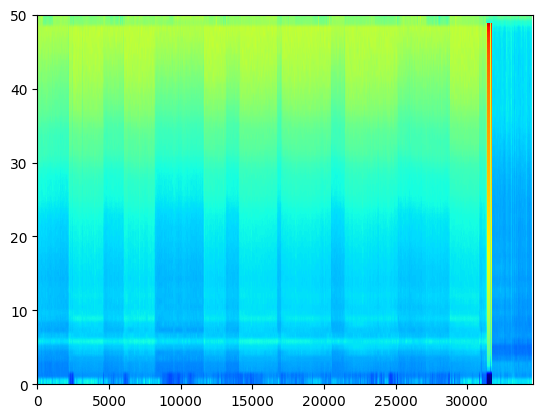

In [60]:
print(f'initialising train dataset for {len(train_file_names)} files')
train_file_paths = [os.path.join(dataset_path, file_name) for file_name in train_file_names]
train_dataset = SpectrogramDataset(train_file_paths)


initialising train dataset for 35 files
number of spectrograms: 510, number of annotations: 510
different spectrogram shape at index 509
509 (65, 26)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 513, number of annotations: 513


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 470, number of annotations: 470


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 498, number of annotations: 498
different spectrogram shape at index 497
497 (65, 29)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 459, number of annotations: 459
different spectrogram shape at index 458
458 (65, 37)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 482, number of annotations: 482


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 400, number of annotations: 400
different spectrogram shape at index 399
399 (65, 31)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 469, number of annotations: 469


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 510, number of annotations: 510
different spectrogram shape at index 509
509 (65, 26)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 483, number of annotations: 483


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 482, number of annotations: 482
different spectrogram shape at index 481
481 (65, 37)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 506, number of annotations: 506
different spectrogram shape at index 505
505 (65, 29)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 538, number of annotations: 538
number of spectrograms: 517, number of annotations: 517


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 557, number of annotations: 557


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 490, number of annotations: 490


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 429, number of annotations: 429
number of spectrograms: 523, number of annotations: 523
different spectrogram shape at index 522
522 (65, 37)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 508, number of annotations: 508
different spectrogram shape at index 507
507 (65, 37)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 495, number of annotations: 495


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 450, number of annotations: 450


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 457, number of annotations: 457
different spectrogram shape at index 456
456 (65, 38)
number of spectrograms: 498, number of annotations: 498


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 527, number of annotations: 527


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 527, number of annotations: 527


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 487, number of annotations: 487
different spectrogram shape at index 486
486 (65, 28)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 520, number of annotations: 520
different spectrogram shape at index 519
519 (65, 38)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 511, number of annotations: 511
number of spectrograms: 505, number of annotations: 505
number of spectrograms: 515, number of annotations: 515
different spectrogram shape at index 514
514 (65, 37)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 509, number of annotations: 509
number of spectrograms: 465, number of annotations: 465
number of spectrograms: 473, number of annotations: 473
number of spectrograms: 475, number of annotations: 475
number of spectrograms: 510, number of annotations: 510


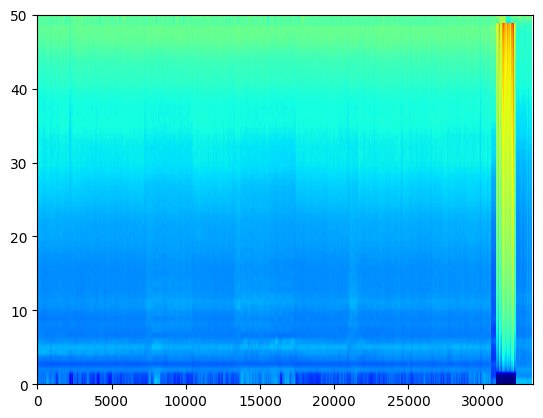

In [61]:
print(f'initialising train dataset for {len(test_file_names)} files')
test_file_paths = [os.path.join(dataset_path, file_name) for file_name in test_file_names]
test_dataset = SpectrogramDataset(test_file_paths)


In [77]:
train_batch_size = 1
train_dl = DataLoader(
    train_dataset,
    batch_size = train_batch_size,
    shuffle = True,
    collate_fn = collate_fn,
    pin_memory = True
)
test_dl = DataLoader(
    test_dataset,
    batch_size = train_batch_size,
    shuffle = False,
    collate_fn = collate_fn,
    pin_memory = True
)

### Creating LSTM architecture

In [78]:
class LSTM(nn.Module):
  def __init__(self, input_dim = 32 * 7 * 7, hidden_dim = 512, num_layers = 1, dropout = 0.4):
    super().__init__()
    self.rnn = nn.LSTM(input_size = input_dim, hidden_size = hidden_dim, num_layers = num_layers, batch_first = False)
    self.dropout = nn.Dropout(dropout)
  def forward(self,src):
    src = self.rnn(src)
    return self.dropout(src)

### Simpler models

In [79]:
!pip install einops

In [80]:
from einops.layers.torch import Rearrange

In [81]:
class PureLSTM(nn.Module):
  def __init__(self, dropout = 0.2):
    super().__init__()
    self.rnn = nn.LSTM(100, 256, 2, dropout = dropout)
    self.bn = nn.BatchNorm1d(1)
    self.relu = nn.LeakyReLU(0.05)
    self.classifier = nn.Sequential(
      nn.Linear(128, 1),
      nn.Sigmoid()
    )
  def forward(self, src):
    outputs, (hidden, cell) = self.rnn(src)
    outputs = self.relu(outputs)
    return self.classifier(outputs[-1])

### Instantiate LSTM model for training

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PureLSTM(0.4)
def init_weights(m):
    for _, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
model.apply(init_weights)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

In [83]:
# %env CUBLAS_WORKSPACE_CONFIG=:16:8

### Defining accuracy, precision and recall scores

In [84]:
def get_accuracy(outputs,target):
    correct = 0
    for output, target in zip(outputs, target):
        if output > 0.5:
          output = 1.0
        else:
          output = 0.0
        if output == target:
            correct += 1
    return correct / len(outputs)
def get_precision(outputs, target):
    TP = 0
    FP = 0
    for output, target in zip(outputs, target):

      if output > 0.5:
        output = 1.0
      else:
        output = 0.0
      if output == 1 and target == 1:
        TP += 1
      elif output == 1 and target == 0:
        FP += 1
    if TP + FP == 0:
      return "NA"
    return TP/(TP+FP)
def get_recall(outputs,target):
    TP = 0
    FN = 0
    for output, target in zip(outputs, target):
      if output > 0.5:
        output = 1.0
      else:
        output = 0.0
      if output == 1 and target == 1:
        TP += 1
      elif output == 0 and target == 1:
        FN += 1
    if TP + FN == 0:
      return "NA"
    return TP/(TP+FN)

### Defining LSTM training function

In [85]:
def train_PureLSTM(model, train_dl, print_interval = 5000):
  current_loss = 0
  current_accuracy = 0
  current_precision = 0
  current_recall = 0
  outputs_ls = []
  trgs_ls = []
  model.train()
  epoch_loss = 0
  epoch_output_ls = []
  epoch_trg_ls = []
  for i,data in enumerate(train_dl):
    optimizer.zero_grad()
    src = [_data[0] for _data in data]
    trg = [_data[1] for _data in data]
    src = torch.stack(src)
    b,c,h,w = src.shape
    src = src.reshape(w,b,c * h)
    src = src.to(device)
    trg = torch.tensor(trg)
    trg = trg.to(device)
    outputs = model(src)
    outputs = outputs.transpose(0,1)
    trg = trg.transpose(0,1)
    loss = criterion(outputs.float(),trg.float())
    current_loss += loss.item()
    epoch_loss += loss.item()
    loss.backward()
    optimizer.step()
    outputs,trg = outputs.view(-1),trg.view(-1)
    epoch_output_ls.extend(outputs.tolist())
    epoch_trg_ls.extend(trg.tolist())
    outputs_ls.extend(outputs.tolist())
    trgs_ls.extend(trg.tolist())
    if i % print_interval == 0 and i > 0:
      current_accuracy = get_accuracy(outputs_ls, trgs_ls)
      precision = get_precision(outputs_ls, trgs_ls)
      recall = get_recall(outputs_ls, trgs_ls)
      current_precision = precision
      current_recall = recall
      print('iter',i * train_batch_size)
      print('outputs')
      print(outputs.tolist())
      print('trg')
      print(trg.tolist())
      print(f'avg accuracy over {print_interval} batches',current_accuracy)
      print(f'avg precision over {print_interval} batches',current_precision)
      print(f'avg recall over {print_interval} batches',current_recall)
      print(f'avg loss over {print_interval} batches',current_loss/print_interval)
      outputs_ls = []
      trgs_ls = []
      current_loss = 0
      current_accuracy = 0
      current_precision = 0
      current_recall = 0
  epoch_loss = epoch_loss/len(train_dl)
  epoch_accuracy = get_accuracy(epoch_output_ls,epoch_trg_ls)
  epoch_precision = get_precision(epoch_output_ls, epoch_trg_ls)
  epoch_recall = get_recall(epoch_output_ls, epoch_trg_ls)
  return {
      "epoch_loss":epoch_loss,
      "epoch_accuracy":epoch_accuracy,
      "epoch_precision":epoch_precision,
      "epoch_recall":epoch_recall
  }

### Defining LSTM evaluation function

In [86]:
def evaluate_PureLSTM(model, test_dl, print_interval = 5000):
  div = 1000
  current_loss = 0
  current_accuracy = 0
  current_precision = 0
  current_recall = 0
  outputs_ls = []
  trgs_ls = []
  epoch_loss = 0
  epoch_output_ls = []
  epoch_trg_ls = []
  model.eval()
  with torch.no_grad():
    for i,data in enumerate(test_dl):
      src = [_data[0] for _data in data]
      trg = [_data[1] for _data in data]
      src = torch.stack(src)
      b,c,h,w = src.shape
      src = src.reshape((w, b, h))
      src = src.to(device)
      trg = torch.tensor(trg)
      trg = trg.to(device)
      # src = src.reshape(w,b,h)
      outputs = model(src)
      outputs = outputs.transpose(0,1)
      trg = trg.transpose(0,1)
      loss = criterion(outputs.float(),trg.float())
      current_loss += loss.item()
      epoch_loss += loss.item()
      epoch_output_ls.append(outputs[0])
      epoch_trg_ls.append(trg[0])
      outputs_ls.append(outputs[0])
      trgs_ls.append(trg[0])
      if i % print_interval == 0:
        current_accuracy += get_accuracy(outputs_ls, trgs_ls)
        precision = get_precision(outputs_ls, trgs_ls)
        recall = get_recall(outputs_ls, trgs_ls)
        current_precision = precision
        current_recall = recall
        print('iter',i * test_batch_size)
        print(f'avg accuracy over {print_interval} batches',current_accuracy)
        print(f'avg precision over {print_interval} batches',current_precision)
        print(f'avg recall over {print_interval} batches',current_recall)
        print(f'avg loss over {print_interval} batches',current_loss/print_interval)
        outputs_ls = []
        trgs_ls = []
        current_loss = 0
        current_accuracy = 0
        current_precision = 0
        current_recall = 0
  epoch_loss = epoch_loss/len(test_dl)
  epoch_accuracy = get_accuracy(epoch_output_ls,epoch_trg_ls)
  epoch_precision = get_precision(epoch_output_ls, epoch_trg_ls)
  epoch_recall = get_recall(epoch_output_ls, epoch_trg_ls)
  return {
      "epoch_loss":epoch_loss,
      "epoch_accuracy":epoch_accuracy,
      "epoch_precision":epoch_precision,
      "epoch_recall":epoch_recall
  }

### Define evaluation step after each epoch of training + model saving

In [87]:
def train_eval_loop(model_name, model, train_func, test_func, train_dl, test_dl, start_epoch = 0, num_epochs = 5, state_dict_name = ""):
  metrics = {
      "model_name":model_name,
      "num_epochs":num_epochs,
      "train":[],
      "test":[]
  }
  for epoch in range(start_epoch,start_epoch + num_epochs):
    print(f"===> epoch: {epoch}")
    print("===> train metrics")
    train_metrics = train_func(model, train_dl)
    print(train_metrics)
    print("===> evaluate")
    test_metrics = test_func(model, test_dl)
    print(test_metrics)
    metrics["train"].append(train_metrics)
    metrics["test"].append(test_metrics)
    # save_state_dict(model, f"{state_dict_name}_{epoch}")
    # upload_state_dict_to_drive(f"{state_dict_name}_{epoch}")
    torch.save(model.state_dict(), state_dict_name+".pth")
  return metrics

In [88]:
model

PureLSTM(
  (rnn): LSTM(100, 128, num_layers=2, dropout=0.4)
  (bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): LeakyReLU(negative_slope=0.05)
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

### Train Eval Loop

In [89]:
from enum import Enum
class Models(Enum):
  CNN_LSTM = "CNN_LSTM"
  PureCNN = "PureCNN"
  PureLSTM = "PureLSTM"

In [90]:
metrics = []

## Start training phase

In [91]:
metrics.append(train_eval_loop(
    Models.PureLSTM.value,
    model,
    train_PureLSTM,
    evaluate_PureLSTM,
    train_dl,test_dl,
    start_epoch = 0,
    num_epochs = 10,
    state_dict_name = "PureLSTM_v9"
))

===> epoch: 0
===> train metrics
iter 5000
outputs
[0.3833853304386139]
trg
[1]
avg accuracy over 5000 batches 0.607878424315137
avg precision over 5000 batches 0.1111111111111111
avg recall over 5000 batches 0.0005117707267144319
avg loss over 5000 batches 0.6724599867016077
iter 10000
outputs
[0.3243158161640167]
trg
[0]
avg accuracy over 5000 batches 0.6144
avg precision over 5000 batches 0.4444444444444444
avg recall over 5000 batches 0.008316008316008316
avg loss over 5000 batches 0.6674522800654172


KeyboardInterrupt: 

## View results/scores for each epoch

In [40]:
flattened_train_metrics = []
flattened_test_metrics = []
for metric_dict in metrics:
  flattened_train_metrics.extend(metric_dict["train"])
  flattened_test_metrics.extend(metric_dict["test"])
print(flattened_test_metrics)

[{'epoch_loss': 0.6741210516850265, 'epoch_accuracy': 0.6206856613388928, 'epoch_precision': 'NA', 'epoch_recall': 0.0}, {'epoch_loss': 0.6862087730910066, 'epoch_accuracy': 0.6206856613388928, 'epoch_precision': 'NA', 'epoch_recall': 0.0}, {'epoch_loss': 0.6585765952934317, 'epoch_accuracy': 0.6206856613388928, 'epoch_precision': 'NA', 'epoch_recall': 0.0}, {'epoch_loss': 0.6515405289349848, 'epoch_accuracy': 0.6206856613388928, 'epoch_precision': 'NA', 'epoch_recall': 0.0}, {'epoch_loss': 0.6300656555700708, 'epoch_accuracy': 0.6517257354644429, 'epoch_precision': 0.5889183808891838, 'epoch_recall': 0.27099236641221375}, {'epoch_loss': 0.6517209420582543, 'epoch_accuracy': 0.6611072504053741, 'epoch_precision': 0.5726175613816064, 'epoch_recall': 0.4201526717557252}, {'epoch_loss': 0.6906493019790686, 'epoch_accuracy': 0.6393907806347, 'epoch_precision': 0.6765027322404371, 'epoch_recall': 0.09450381679389314}, {'epoch_loss': 0.6266964530790294, 'epoch_accuracy': 0.6653347231873986, 

## Plotting

In [41]:
loss_plot = [metric["epoch_loss"] for metric in flattened_test_metrics]
precision_plot = [metric["epoch_precision"] for metric in flattened_test_metrics]
accuracy_plot = [metric["epoch_accuracy"] for metric in flattened_test_metrics]
recall_plot = [metric["epoch_recall"] for metric in flattened_test_metrics]

(10,)
(10,)


<Figure size 10000x1000 with 0 Axes>

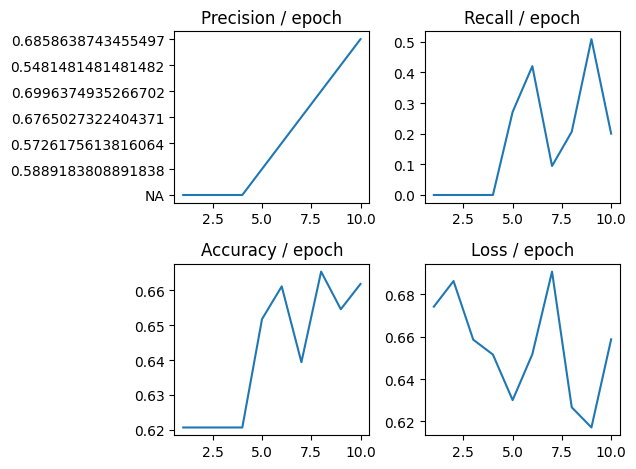

In [42]:
X = np.arange(1,11)
print(X.shape)
print(np.array(precision_plot).shape)
plt.figure(figsize=(100,10))

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)

# For Sine Function
axis[0, 0].plot(X, np.array(precision_plot))
axis[0, 0].set_title("Precision / epoch")

# For Cosine Function
axis[0, 1].plot(X, np.array(recall_plot))
axis[0, 1].set_title("Recall / epoch")

# For Tangent Function
axis[1, 0].plot(X, np.array(accuracy_plot))
axis[1, 0].set_title("Accuracy / epoch")

# For Tanh Function
axis[1, 1].plot(X, np.array(loss_plot))
axis[1, 1].set_title("Loss / epoch")
plt.tight_layout()
plt.savefig('PureLSTM_v9')

plt.show()
# # Image.open('128_conv_1024_hidden_2_layer_lstm.png').save('128_conv_1024_hidden_2_layer_lstm.jpg','JPEG')